In [1]:
%env WANDB_PROJECT=StackOverflow

env: WANDB_PROJECT=StackOverflow


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from dateutil.parser import parse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          EarlyStoppingCallback, EvalPrediction)
from transformers.integrations import TensorBoardCallback

# increase the row lenght in pandas
pd.set_option('display.max_colwidth', 512)
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
# First look at the dataframe
df = pd.read_csv('data/DS_Interview_Dataset.csv', encoding='ISO-8859-1')
df.head(10)

,ID,CREATIONDATE,SCORE,TITLE,TAGS
0,1722730,2009-11-12T14:51:00.663Z,4,File paths in Java (Linux),|java|linux|file-io|
1,1722749,2009-11-12T14:53:22.077Z,213,How to use RSpec's should_raise with any kind of exception?,|ruby-on-rails|ruby|exception|rspec|
2,1722795,2009-11-12T14:58:42.723Z,23,iOS UINavigationBar vs UIToolbar vs UITabBar,|ios|iphone|xcode|interface-builder|
3,1722855,2009-11-12T15:06:37.717Z,1,In swing GUI how to show a JPanel as maximized when the user clicks a button?,|java|swing|jpanel|
4,1722863,2009-11-12T15:07:59.473Z,1,How to click a link from javascript,|javascript|
5,1722864,2009-11-12T15:08:16.403Z,5,Disable default ALT key action in JFrame under Windows,|java|windows|swing|
6,1722865,2009-11-12T15:08:47.803Z,1,Twisted/tkinter program crashes on exit,|python|twisted|tkinter|
7,1722896,2009-11-12T15:12:12.54Z,43,VB to C# Functions,|c#|vb.net|operators|vb.net-to-c#|
8,1722901,2009-11-12T15:12:40.183Z,1,Is the first entry in sys.path supposed to represent the current working directory?,|python|pythonpath|sys.path|
9,1722916,2009-11-12T15:14:29.37Z,2,how to link c++ program with HTML page?,|c++|html|c|


Preprocessing the tags to extract only the relevant task for our case. 

In [4]:
labels = ['python', 'javascript', 'ios', 'c#', 'java', 'ruby-on-rails', 'mysql', 'html', 'matplotlib']

def extract_tags(tags):
    """
    Function to extract relevant tags from tags column
    Parameters: 
        tags(series): tags column 
    Returns:
        relevant_tags(series): tags_relevant column 
    """
    tags = tags.replace('|', ' ').split()
    relevant_tags = [tag for tag in tags if tag in labels]
    return relevant_tags


df['TAGS_relevant'] = df['TAGS'].apply(extract_tags)
df.head()

,ID,CREATIONDATE,SCORE,TITLE,TAGS,TAGS_relevant
0,1722730,2009-11-12T14:51:00.663Z,4,File paths in Java (Linux),|java|linux|file-io|,[java]
1,1722749,2009-11-12T14:53:22.077Z,213,How to use RSpec's should_raise with any kind of exception?,|ruby-on-rails|ruby|exception|rspec|,[ruby-on-rails]
2,1722795,2009-11-12T14:58:42.723Z,23,iOS UINavigationBar vs UIToolbar vs UITabBar,|ios|iphone|xcode|interface-builder|,[ios]
3,1722855,2009-11-12T15:06:37.717Z,1,In swing GUI how to show a JPanel as maximized when the user clicks a button?,|java|swing|jpanel|,[java]
4,1722863,2009-11-12T15:07:59.473Z,1,How to click a link from javascript,|javascript|,[javascript]


Here we can see that we have 129 examples that contains more than 1 relevant tag, so we should create a multi-label classification task.

In [5]:
tags_count_per_row = df['TAGS_relevant'].apply(len)

more_than_one_tag = df[tags_count_per_row > 1]
more_than_one_tag

,ID,CREATIONDATE,SCORE,TITLE,TAGS,TAGS_relevant
71,1723975,2009-11-12T17:29:22.213Z,1,difference in mouse events on img/div,|javascript|html|,"[javascript, html]"
92,1724460,2009-11-12T18:45:09.07Z,2,Storing the path of a file a user selects from the file input as a session variable to repopulate the field later,|php|javascript|html|css|dom|,"[javascript, html]"
108,1724739,2009-11-12T19:27:02.96Z,19,Back Button Handle A Dynamic Form,|javascript|html|forms|back-button|,"[javascript, html]"
109,1724743,2009-11-12T19:27:20.123Z,3,"Using jQuery, setting Draggable on an element prevents blur from firing when you click the draggable element",|javascript|html|jquery|jquery-ui|jquery-events|,"[javascript, html]"
126,1725079,2009-11-12T20:17:49.867Z,2,"Entity Framework Error message MYSQL, works on the local machine not when published",|c#|asp.net|mysql|,"[c#, mysql]"
...,...,...,...,...,...,...
2811,1763113,2009-11-19T12:57:22.183Z,2,Why does select with onfocus not work in IE?,|javascript|html|css|internet-explorer|,"[javascript, html]"
2820,1763211,2009-11-19T13:13:33.713Z,16,Apply CSS for an HTML generic control like <UL> and <LI> in ASP.NET,|c#|.net|asp.net|html|css|,"[c#, html]"
2837,1763479,2009-11-19T14:02:52.117Z,115,How to get the HTML for a DOM element in javascript,|javascript|html|dom|,"[javascript, html]"
2890,1764370,2009-11-19T16:01:17.74Z,7,Use of Mocks in Tests,|c#|java|unit-testing|testing|mocking|,"[c#, java]"


We also have some titles without relevant labels

In [6]:
df[tags_count_per_row < 1].head()

,ID,CREATIONDATE,SCORE,TITLE,TAGS,TAGS_relevant
38,1723364,2009-11-12T16:09:51.893Z,1,Pattern to catch exception from sections of code (while not making eyes bleed),|.net|exception|c#-3.0|code-readability|,[]
65,1723875,2009-11-12T17:16:28.34Z,39,Can method parameters be dynamic in C#,|dynamic|parameters|methods|c#-4.0|,[]
119,1724927,2009-11-12T19:54:04.563Z,5,ASP.Net MVC 2.0 Html.HiddenFor HtmlHelper extension doesn't return the Value,|asp.net-mvc|asp.net-mvc-2|html-helper|,[]
165,1725831,2009-11-12T22:22:50.99Z,3,When should I use HtmlHelper Extension Methods?,|asp.net-mvc|extension-methods|html-helper|,[]
218,1726603,2009-11-13T01:36:09.587Z,2,Using MIDP Canvas keyPressed / keyCode on BlackBerry to get Canvas.FIRE for trackball click,|blackberry|java-me|midp|lcdui|,[]


We drop those with less than 1 tag, since we can't train our model


In [7]:
df = df[tags_count_per_row >= 1]

From a bird's eye view, the titles appear to be clean for the most part. Not much cleaning work is needed

In [8]:
df['TITLE'] = df['TITLE'].str.lower()
df['TITLE'].head(50)

0                                                                                file paths in java (linux)
1                                               how to use rspec's should_raise with any kind of exception?
2                                                              ios uinavigationbar vs uitoolbar vs uitabbar
3                             in swing gui how to show a jpanel as maximized when the user clicks a button?
4                                                                       how to click a link from javascript
5                                                    disable default alt key action in jframe under windows
6                                                                   twisted/tkinter program crashes on exit
7                                                                                        vb to c# functions
8                       is the first entry in sys.path supposed to represent the current working directory?
9                           

In [9]:
df['CREATIONDATE'] = df['CREATIONDATE'].apply(parse)


In [10]:
# Start by exploding the 'TAGS_relevant' column into separate rows
exploded_df = df.explode('TAGS_relevant')

# Set the date as the index for resampling
exploded_df.set_index('CREATIONDATE', inplace=True)

# Resample by month and count the occurrences of each tag
tag_counts = exploded_df.resample('M')['TAGS_relevant'].value_counts().unstack().fillna(0)

# Display the resulting DataFrame
print(tag_counts)


TAGS_relevant                 c#   html   ios   java  javascript  matplotlib   
CREATIONDATE                                                                   
2009-11-30 00:00:00+00:00  829.0  179.0  11.0  527.0       355.0         4.0  \
2014-09-30 00:00:00+00:00   57.0   22.0  37.0   88.0        60.0         0.0   
2022-08-31 00:00:00+00:00   17.0   10.0   4.0   13.0        47.0         2.0   

TAGS_relevant              mysql  python  ruby-on-rails  
CREATIONDATE                                             
2009-11-30 00:00:00+00:00  184.0   316.0          150.0  
2014-09-30 00:00:00+00:00   13.0    37.0           16.0  
2022-08-31 00:00:00+00:00    7.0    56.0            1.0  


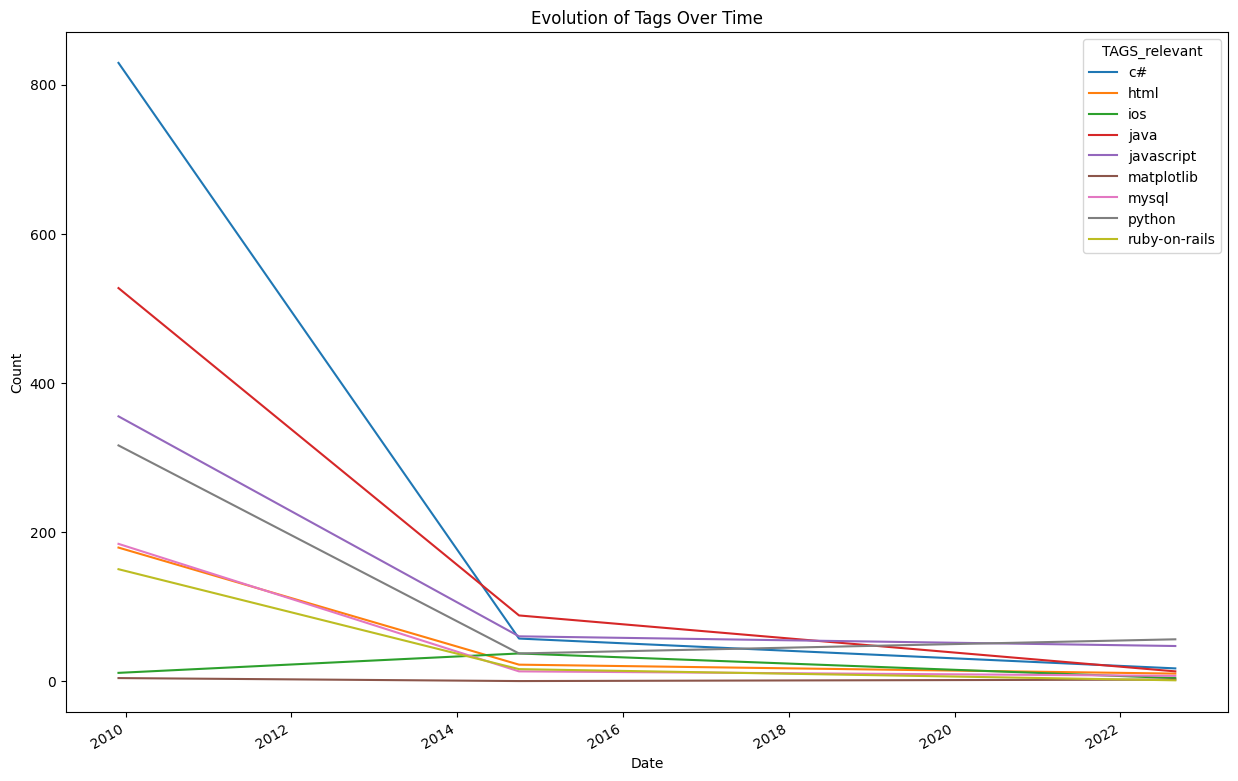

In [11]:
tag_counts.plot(kind='line', figsize=(15, 10))
plt.title('Evolution of Tags Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

Create a mapping between labels and idx


In [12]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [13]:
# model_name = "microsoft/deberta-v3-base"
model_name = "microsoft/xtremedistil-l6-h384-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["TITLE"]
  # encode them
  encoding = tokenizer(text, padding=True, truncation=True, max_length=128)
  # add labels
  labels_batch = examples["TAGS_relevant"]
  # create numpy array of shape (batch_size, num_labels) using list comprehension and vectorization
  labels_matrix = np.array([[float(label in lb) for label in labels] for lb in labels_batch])

  encoding["labels"] = labels_matrix.tolist()

  return encoding

In [15]:
# Load our pandas dataframe into a HuggingFace dataset
my_dataset = Dataset.from_pandas(df)

# Split the dataset into training and testing sets, with a 10% split for the test set
my_dataset_splits = my_dataset.train_test_split(test_size=0.10, seed=11, shuffle=False)

# Further split the test set into validation and test sets
evaluation_and_test = my_dataset_splits['test'].train_test_split(test_size=0.5)

# Organize the splits into a dictionary for convenient access
dataset = DatasetDict({
    "train": my_dataset_splits['train'],
    "valid": evaluation_and_test['train'],
    "test": evaluation_and_test['test']
})
dataset


DatasetDict({
    train: Dataset({
        features: ['ID', 'CREATIONDATE', 'SCORE', 'TITLE', 'TAGS', 'TAGS_relevant', '__index_level_0__'],
        num_rows: 2619
    })
    valid: Dataset({
        features: ['ID', 'CREATIONDATE', 'SCORE', 'TITLE', 'TAGS', 'TAGS_relevant', '__index_level_0__'],
        num_rows: 145
    })
    test: Dataset({
        features: ['ID', 'CREATIONDATE', 'SCORE', 'TITLE', 'TAGS', 'TAGS_relevant', '__index_level_0__'],
        num_rows: 146
    })
})

In [16]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/2619 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

In [17]:
batch_size = 16
metric_name = "loss"

In [18]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(f"models/{model_name}_fine_tuned",
                         evaluation_strategy="epoch",
                         save_strategy="epoch",
                         save_total_limit=1,
                         learning_rate=2e-5,
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         num_train_epochs=50,
                         load_best_model_at_end=True,
                         metric_for_best_model=metric_name,
                         fp16=True,
                         weight_decay=0.02,
                         optim='adafactor',
                         report_to="wandb",
                         run_name=model_name
                         )


In [19]:
def compute_model_metrics(preds, actual_labels, cut_off=0.5):
    # Applying the sigmoid function to predictions, which are of the shape (batch_size, num_labels)
    sigmoid_func = torch.nn.Sigmoid()
    probabilities = sigmoid_func(torch.Tensor(preds))

    # Using the threshold value to convert probabilities into binary predictions
    binary_preds = np.zeros(probabilities.shape)
    binary_preds[np.where(probabilities >= cut_off)] = 1

    # Computing various metrics
    true_labels = actual_labels
    f1_micro_avg = f1_score(y_true=true_labels,
                            y_pred=binary_preds,
                            average='micro')
    auc_roc = roc_auc_score(y_true=true_labels,
                            y_score=binary_preds,
                            average='micro')
    model_accuracy = accuracy_score(y_true=true_labels, y_pred=binary_preds)

    # Packing the metrics into a dictionary for easy access
    calculated_metrics = {
        'f1': f1_micro_avg,
        'roc_auc': auc_roc,
        'accuracy': model_accuracy
    }

    return calculated_metrics


def compute_metrics(evaluation_prediction: EvalPrediction):
    # If predictions are a tuple, take the first element
    predicted_values = evaluation_prediction.predictions[0] if isinstance(
        evaluation_prediction.predictions,
        tuple) else evaluation_prediction.predictions

    # Using the compute_model_metrics function to calculate the metrics
    calculated_results = compute_model_metrics(
        preds=predicted_values, actual_labels=evaluation_prediction.label_ids)

    return calculated_results


In [20]:
trainer = Trainer(model,
                  args,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  callbacks=[
                      EarlyStoppingCallback(early_stopping_patience=10),
                      TensorBoardCallback(),
                  ])

In [21]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaceladri. Use `wandb login --relogin` to force relogin


  0%|          | 0/8200 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3919059634208679, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0867, 'eval_samples_per_second': 1683.057, 'eval_steps_per_second': 115.278, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.3207377791404724, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0818, 'eval_samples_per_second': 1785.081, 'eval_steps_per_second': 122.266, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2993725836277008, 'eval_f1': 0.18072289156626503, 'eval_roc_auc': 0.5496688741721855, 'eval_accuracy': 0.10273972602739725, 'eval_runtime': 0.1531, 'eval_samples_per_second': 953.38, 'eval_steps_per_second': 65.3, 'epoch': 3.0}
{'loss': 0.3927, 'learning_rate': 1.878048780487805e-05, 'epoch': 3.05}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.28689366579055786, 'eval_f1': 0.3383084577114428, 'eval_roc_auc': 0.6057040196340817, 'eval_accuracy': 0.22602739726027396, 'eval_runtime': 0.1017, 'eval_samples_per_second': 1435.486, 'eval_steps_per_second': 98.321, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.27425315976142883, 'eval_f1': 0.2918918918918919, 'eval_roc_auc': 0.5863945152124274, 'eval_accuracy': 0.18493150684931506, 'eval_runtime': 0.1083, 'eval_samples_per_second': 1347.665, 'eval_steps_per_second': 92.306, 'epoch': 5.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2662460505962372, 'eval_f1': 0.3191489361702127, 'eval_roc_auc': 0.5963282900468644, 'eval_accuracy': 0.19863013698630136, 'eval_runtime': 0.0847, 'eval_samples_per_second': 1723.35, 'eval_steps_per_second': 118.038, 'epoch': 6.0}
{'loss': 0.2759, 'learning_rate': 1.75609756097561e-05, 'epoch': 6.1}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2525421679019928, 'eval_f1': 0.4205607476635514, 'eval_roc_auc': 0.6412680154658253, 'eval_accuracy': 0.3013698630136986, 'eval_runtime': 0.089, 'eval_samples_per_second': 1640.028, 'eval_steps_per_second': 112.331, 'epoch': 7.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25411951541900635, 'eval_f1': 0.4678899082568808, 'eval_roc_auc': 0.6619954103625585, 'eval_accuracy': 0.3493150684931507, 'eval_runtime': 0.0852, 'eval_samples_per_second': 1713.091, 'eval_steps_per_second': 117.335, 'epoch': 8.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.24974483251571655, 'eval_f1': 0.4705882352941176, 'eval_roc_auc': 0.6644468234128452, 'eval_accuracy': 0.3561643835616438, 'eval_runtime': 0.0849, 'eval_samples_per_second': 1719.204, 'eval_steps_per_second': 117.754, 'epoch': 9.0}
{'loss': 0.2265, 'learning_rate': 1.6341463414634145e-05, 'epoch': 9.15}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2530432343482971, 'eval_f1': 0.5286343612334802, 'eval_roc_auc': 0.6917967348658698, 'eval_accuracy': 0.3904109589041096, 'eval_runtime': 0.1282, 'eval_samples_per_second': 1139.129, 'eval_steps_per_second': 78.023, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2480991780757904, 'eval_f1': 0.5423728813559322, 'eval_roc_auc': 0.7028921549088052, 'eval_accuracy': 0.4178082191780822, 'eval_runtime': 0.0992, 'eval_samples_per_second': 1471.901, 'eval_steps_per_second': 100.815, 'epoch': 11.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2420458346605301, 'eval_f1': 0.5668016194331983, 'eval_roc_auc': 0.7206100915080318, 'eval_accuracy': 0.4589041095890411, 'eval_runtime': 0.1144, 'eval_samples_per_second': 1276.246, 'eval_steps_per_second': 87.414, 'epoch': 12.0}
{'loss': 0.1874, 'learning_rate': 1.5121951219512196e-05, 'epoch': 12.2}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.251828134059906, 'eval_f1': 0.5770750988142291, 'eval_roc_auc': 0.7292540985006805, 'eval_accuracy': 0.4794520547945205, 'eval_runtime': 0.1069, 'eval_samples_per_second': 1366.381, 'eval_steps_per_second': 93.588, 'epoch': 13.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.23964323103427887, 'eval_f1': 0.5714285714285714, 'eval_roc_auc': 0.7259428402225346, 'eval_accuracy': 0.4726027397260274, 'eval_runtime': 0.1045, 'eval_samples_per_second': 1397.001, 'eval_steps_per_second': 95.685, 'epoch': 14.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.24460983276367188, 'eval_f1': 0.5900383141762453, 'eval_roc_auc': 0.7407794411575453, 'eval_accuracy': 0.5068493150684932, 'eval_runtime': 0.117, 'eval_samples_per_second': 1248.226, 'eval_steps_per_second': 85.495, 'epoch': 15.0}
{'loss': 0.1581, 'learning_rate': 1.3902439024390244e-05, 'epoch': 15.24}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25115257501602173, 'eval_f1': 0.5735849056603773, 'eval_roc_auc': 0.7353185698097521, 'eval_accuracy': 0.5, 'eval_runtime': 0.1163, 'eval_samples_per_second': 1255.298, 'eval_steps_per_second': 85.979, 'epoch': 16.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2502478361129761, 'eval_f1': 0.5846153846153845, 'eval_roc_auc': 0.7374681828793995, 'eval_accuracy': 0.5, 'eval_runtime': 0.0875, 'eval_samples_per_second': 1667.838, 'eval_steps_per_second': 114.235, 'epoch': 17.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2510429918766022, 'eval_f1': 0.5823754789272031, 'eval_roc_auc': 0.73703826026547, 'eval_accuracy': 0.5, 'eval_runtime': 0.0982, 'eval_samples_per_second': 1486.677, 'eval_steps_per_second': 101.827, 'epoch': 18.0}
{'loss': 0.1367, 'learning_rate': 1.2682926829268294e-05, 'epoch': 18.29}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.24706126749515533, 'eval_f1': 0.5977859778597785, 'eval_roc_auc': 0.751444938586551, 'eval_accuracy': 0.5273972602739726, 'eval_runtime': 0.0837, 'eval_samples_per_second': 1744.933, 'eval_steps_per_second': 119.516, 'epoch': 19.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2507360279560089, 'eval_f1': 0.5917602996254682, 'eval_roc_auc': 0.7456822672581187, 'eval_accuracy': 0.5205479452054794, 'eval_runtime': 0.1115, 'eval_samples_per_second': 1309.61, 'eval_steps_per_second': 89.699, 'epoch': 20.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25056901574134827, 'eval_f1': 0.5917602996254682, 'eval_roc_auc': 0.7456822672581187, 'eval_accuracy': 0.5205479452054794, 'eval_runtime': 0.0967, 'eval_samples_per_second': 1510.592, 'eval_steps_per_second': 103.465, 'epoch': 21.0}
{'loss': 0.1193, 'learning_rate': 1.1463414634146342e-05, 'epoch': 21.34}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25835105776786804, 'eval_f1': 0.5947955390334573, 'eval_roc_auc': 0.7485636029223349, 'eval_accuracy': 0.5273972602739726, 'eval_runtime': 0.0822, 'eval_samples_per_second': 1775.181, 'eval_steps_per_second': 121.588, 'epoch': 22.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25531327724456787, 'eval_f1': 0.6, 'eval_roc_auc': 0.7518748612004805, 'eval_accuracy': 0.5342465753424658, 'eval_runtime': 0.098, 'eval_samples_per_second': 1489.531, 'eval_steps_per_second': 102.023, 'epoch': 23.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.25482994318008423, 'eval_f1': 0.6029411764705882, 'eval_roc_auc': 0.7547561968646969, 'eval_accuracy': 0.541095890410959, 'eval_runtime': 0.0835, 'eval_samples_per_second': 1747.741, 'eval_steps_per_second': 119.708, 'epoch': 24.0}
{'train_runtime': 235.5015, 'train_samples_per_second': 556.047, 'train_steps_per_second': 34.819, 'train_loss': 0.20183407485000487, 'epoch': 24.0}


TrainOutput(global_step=3936, training_loss=0.20183407485000487, metrics={'train_runtime': 235.5015, 'train_samples_per_second': 556.047, 'train_steps_per_second': 34.819, 'train_loss': 0.20183407485000487, 'epoch': 24.0})

In [22]:
text = dataset['test']['TITLE'][0]

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits

# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['c#']


In [20]:
def optuna_hp_space(trial):

    return {
        "learning_rate":
        trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size":
        trial.suggest_categorical("per_device_train_batch_size",
                                  [16, 32, 64, 128]),
        "weight_decay":
        trial.suggest_float("weight_decay", 0.005, 0.06)
    }


def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        problem_type="multi_label_classification",
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id)

In [21]:
trainer = Trainer(model,
                  args,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  model_init=model_init,
                  callbacks=[
                      EarlyStoppingCallback(early_stopping_patience=10),
                      TensorBoardCallback()
                  ])

/home/ad/mambaforge/envs/stack/lib/python3.10/site-packages/transformers/trainer.py:359: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
EarlyStoppingCallback


In [ ]:
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=10,
    study_name=f"{model_name}-optimization",
    load_if_exists=True,
)